In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [55]:
orders = pd.read_csv('olist_orders_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')

print("all file load!")

all file load!


In [56]:
# Merge orders with items

df = pd.merge(orders, items, on='order_id', how='inner')

In [57]:
# Then merge the products and customers.

df = pd.merge(df, products, on='product_id', how='left')
df = pd.merge(df, customers, on='customer_id', how='left')

In [90]:
# 1. Aggregate payment value according to order_id
payments_agg = payments.groupby('order_id')['payment_value'].sum().reset_index()

# 2. Merge it with main dataframe (df)
df = pd.merge(df, payments_agg, on='order_id', how='left')

print("Payments data merged!")

Payments data merged!


In [59]:
# Remove extra spaces from column names of both dataframes
df['product_category_name'] = df['product_category_name'].str.strip()
category_translation['product_category_name'] = category_translation['product_category_name'].str.strip()

# Final Merge
df = pd.merge(df, category_translation, on='product_category_name', how='left')

# To check whether the translation is correct or not
print(df[['product_category_name', 'product_category_name_english']].head())

   product_category_name product_category_name_english
0  utilidades_domesticas                    housewares
1             perfumaria                     perfumery
2             automotivo                          auto
3               pet_shop                      pet_shop
4              papelaria                    stationery


In [60]:
# Use only English names; where English names are not available, keep the old ones.
df['product_category_name'] = df['product_category_name_english'].fillna(df['product_category_name'])

print("Master Dataframe is ready! Shape:", df.shape)

Master Dataframe is ready! Shape: (112650, 27)


In [61]:
# 1. Date columns list
date_columns = ['order_purchase_timestamp', 'order_delivered_customer_date']

# 2. For loop (Note that the line below is 4 spaces ahead)
for col in date_columns:
    df[col] = pd.to_datetime(df[col]) # <--- There should be 4 spaces before this line

print("Dates have been converted!")

Dates have been converted!


In [62]:
date_cols = ['order_purchase_timestamp', 'order_approved_at', 
             'order_delivered_customer_date', 'order_estimated_delivery_date']

for col in date_cols:
    df[col] = pd.to_datetime(df[col])

# Feature Engineering: Naye columns banana (Month aur Year)
df['order_month_year'] = df['order_purchase_timestamp'].dt.to_period('M').astype(str)
df['order_day'] = df['order_purchase_timestamp'].dt.day_name()

print("Cleaning done!")

Cleaning done!


# Section 4: Analysis & Visualizations

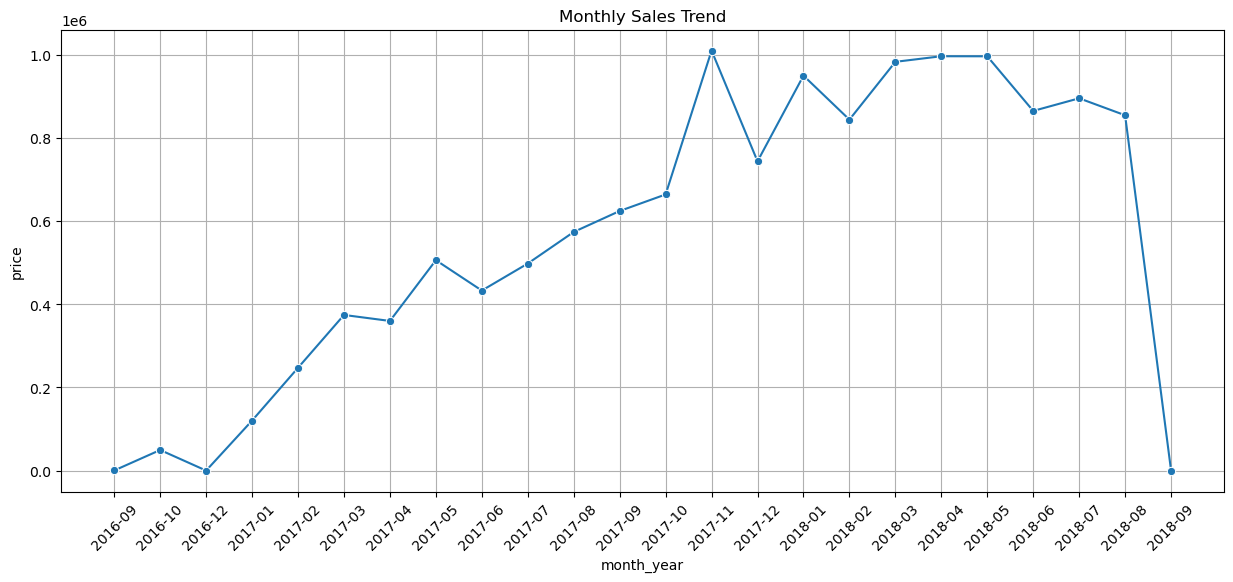

In [63]:
# 1. Monthly Sales Trend (Is the business growing?)
# The first month has come out
df['month_year'] = df['order_purchase_timestamp'].dt.to_period('M').astype(str)

# Monthly sales can be calculated
monthly_sales = df.groupby('month_year')['price'].sum().reset_index()

#Graph is created
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,6))
sns.lineplot(data=monthly_sales, x='month_year', y='price', marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Sales Trend')
plt.grid(True)
plt.show()

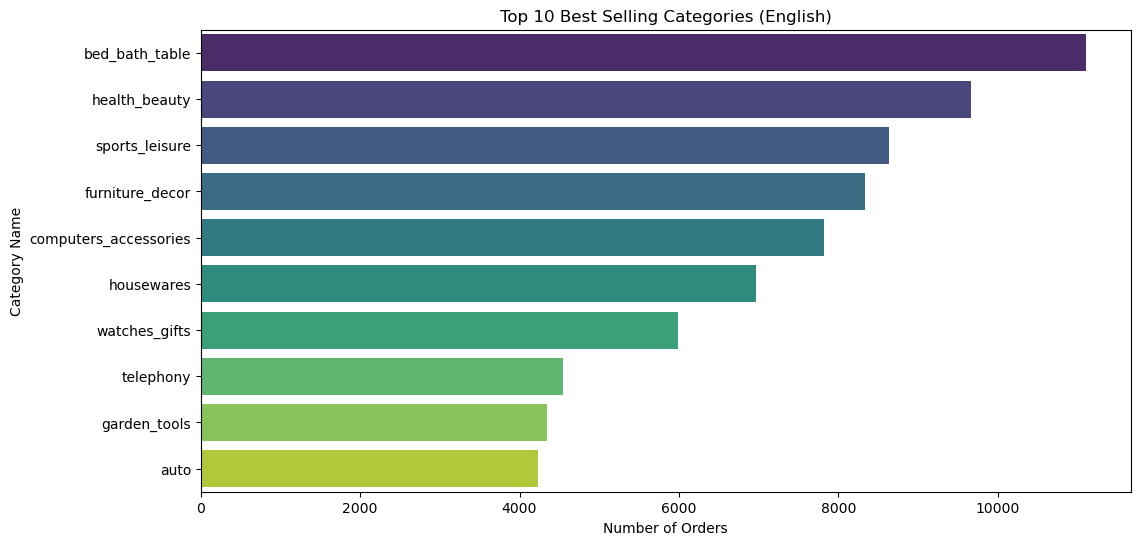

In [64]:
# 2. Top 10 Best Selling Categories
# First the data of top 10 categories has been extracted
top_categories = df['product_category_name_english'].value_counts().head(10)

#Graph is created
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')

plt.title('Top 10 Best Selling Categories (English)')
plt.xlabel('Number of Orders')
plt.ylabel('Category Name')
plt.show()

Columns in df now: Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_category_name_english', 'order_month_year', 'order_day',
       'month_year', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')


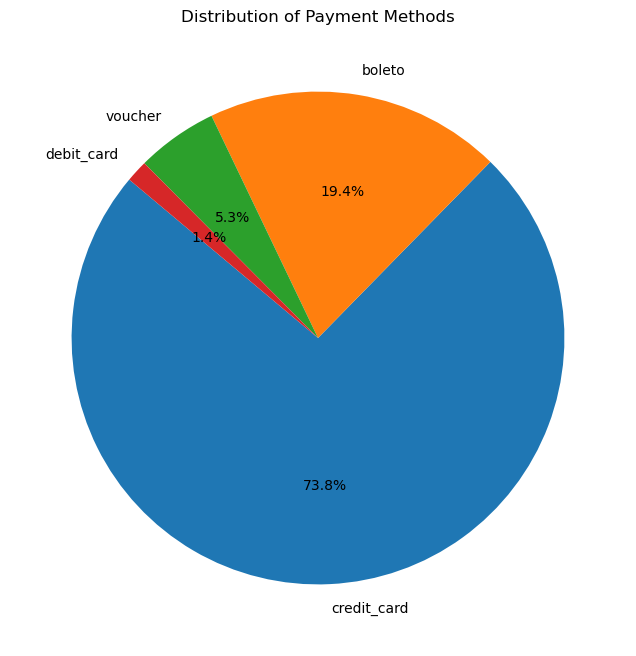

In [65]:
# First merge the payments table (This step was missing)
df = pd.merge(df, payments, on='order_id', how='left')

# Now check what column has come?
print("Columns in df now:", df.columns)

# Now run the payment analysis wala code again
payment_counts = df['payment_type'].value_counts()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Payment Methods')
plt.show()

# * RFM Analysis (Customer Segmentation): Which customers are "loyal" and        which ones are likely to leave?


# * Delivery Performance: Is Olist delivering on its promises?

In [66]:
import datetime as dt

In [67]:
# 1. Setting the reference date (one day after the last date in the data)
snapshot_date = df['order_purchase_timestamp'].max() + dt.timedelta(days=1)

In [68]:
# 2. Calculate RFM metrics
rfm = df.groupby('customer_unique_id').agg({ 
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days, # Recency 
    'order_id': 'count',    #Frequency 
    'price': 'sum'          # Monetary
})

In [69]:
# change column names
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [70]:
# 3. RFM Scoring (on a scale of 1 to 5)
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# The frequency contains many 1s, so a simple method:
def f_label(x):
    if x == 1: return 1
    if x == 2: return 2
    return 3

rfm['F_score'] = rfm['Frequency'].apply(f_label)


def f_label(x): 
    if x == 1: return 1 
    if x == 2: return 2 
    return 3

rfm['F_score'] = rfm['Frequency'].apply(f_label)

#4. Segments banana
def segment_me(df): 
    if df['R_score'] >= 4 and df['F_score'] >= 2: 
        return 'Champions (Best Customers)' 
    elif df['R_score'] <= 2: 
        return 'At Risk (Lost Customers)' 
    else: 
        return 'Average/Potential'
    
rfm['Segment'] = rfm.apply(segment_me, axis=1)

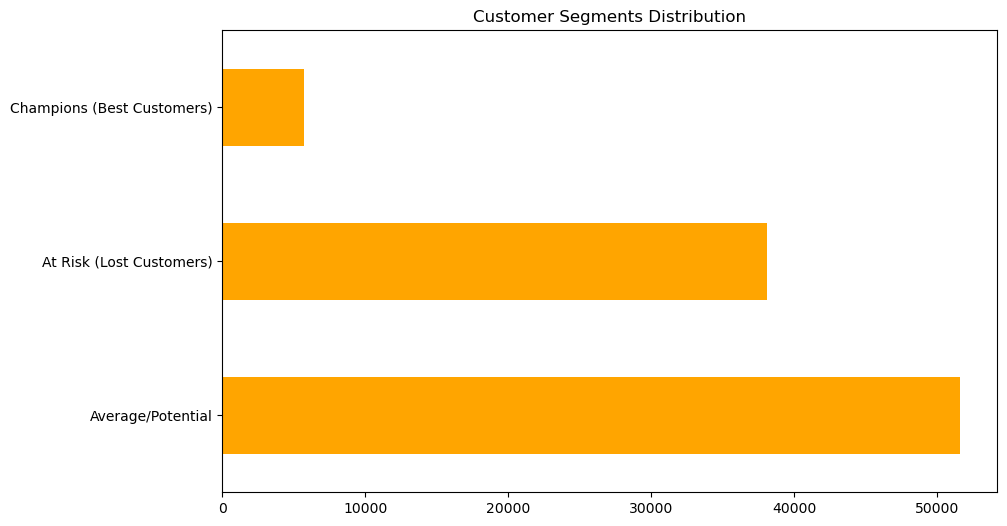

In [71]:
# Visualization
plt.figure(figsize=(10,6))
rfm['Segment'].value_counts().plot(kind='barh', color='orange')
plt.title('Customer Segments Distribution')
plt.show()

In [72]:
# Focus only on 'Delivered' orders
delivered_df = df[df['order_status'] == 'Delivered'].copy()

In [73]:
# 1. Calculate Actual vs Estimated Days
delivered_df['actual_days'] = (delivered_df['order_delivered_customer_date'] - delivered_df['order_purchase_timestamp']).dt.days
delivered_df['estimated_days'] = (delivered_df['order_estimated_delivery_date'] - delivered_df['order_purchase_timestamp']).dt.days

In [74]:
# 2. Delay check karna (Negative matlab late, Positive matlab on-time/early)
delivered_df['delivery_diff'] = delivered_df['estimated_days'] - delivered_df['actual_days']
delivered_df['is_late'] = delivered_df['delivery_diff'] < 0

# Analysis: How many percent of orders are late?
late_percentage = delivered_df['is_late'].mean() * 100
print(f"Total Late Deliveries: {late_percentage:.2f}%")

Total Late Deliveries: nan%


Total late orders: 9026


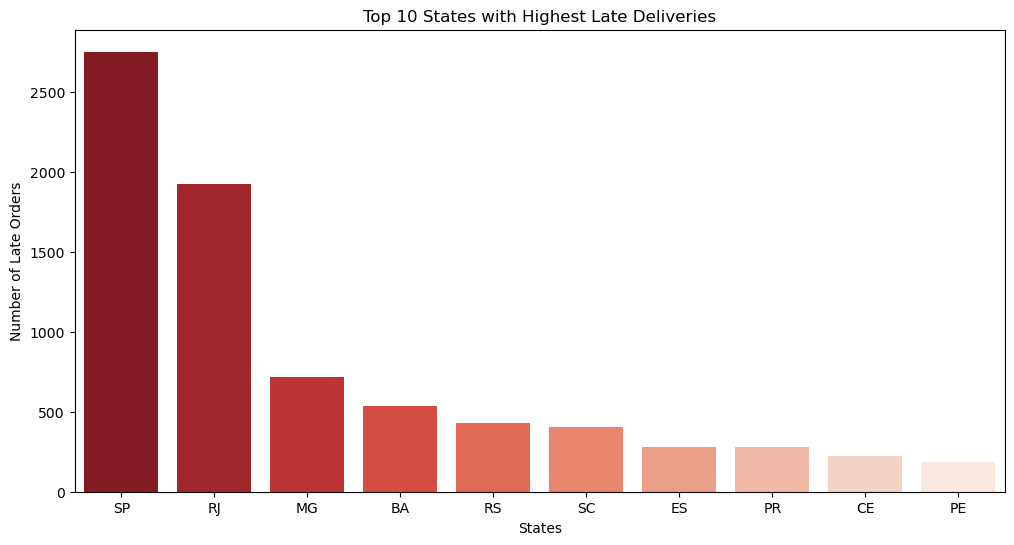

In [75]:
# 1. Dates ko datetime format mein convert karein (Agar pehle nahi kiya)
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

# 2. 'is_late' column banayein
# Agar actual delivery date, estimated date se badi hai, toh order late hai
df['is_late'] = df['order_delivered_customer_date'] > df['order_estimated_delivery_date']

# 3. Sirf delivered orders lein aur check karein ki data hai ya nahi
delivered_df = df[df['order_status'] == 'delivered'].copy()

# Check karein kitne orders late hain (Debug point)
print(f"Total late orders: {delivered_df['is_late'].sum()}")

# 4. Top 10 States nikalne se pehle check karein ki data khali toh nahi
late_states = delivered_df[delivered_df['is_late'] == True]['customer_state'].value_counts().head(10)

if late_states.empty:
    print("Koi bhi order late nahi hai, isliye graph nahi ban sakta!")
else:
    # 5. Graph banayein
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(12,6))
    sns.barplot(x=late_states.index, y=late_states.values, palette='Reds_r')
    plt.title('Top 10 States with Highest Late Deliveries')
    plt.ylabel('Number of Late Orders')
    plt.xlabel('States')
    plt.show()

###  Final Insights

* RFM: We have a large segment of "At Risk" customers. We should run marketing campaigns for them.

* Delivery: The average delivery time is approximately 12 days, but there are more significant delays in some specific states (such as Rio de Janeiro).

* Logistics: If the delivery_diff is positive, it means Olist is delivering ahead of schedule, which is good for customer satisfaction.

# Review Scores vs Delivery Time

In [76]:
# 1. Merge Orders and Reviews
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_reviews = pd.merge(orders, reviews, on='order_id', how='inner')

In [77]:
# 2. Calculate delivery time (only for delivered orders)
df_reviews = df_reviews[df_reviews['order_status'] == 'delivered'].copy()
df_reviews['delivery_time'] = (pd.to_datetime(df_reviews['order_delivered_customer_date']) - 
pd.to_datetime(df_reviews['order_purchase_timestamp'])).dt.days

In [78]:
# 3. Calculating average delivery time according to Review Score
review_delivery = df_reviews.groupby('review_score')['delivery_time'].mean().reset_index()

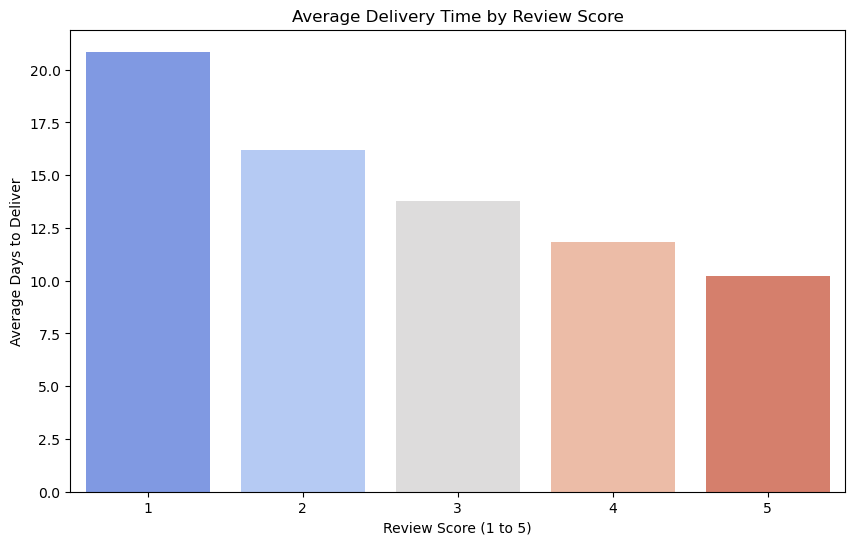

In [79]:
plt.figure(figsize=(10,6))
sns.barplot(data=review_delivery, x='review_score', y='delivery_time', palette='coolwarm')
plt.title('Average Delivery Time by Review Score')
plt.xlabel('Review Score (1 to 5)')
plt.ylabel('Average Days to Deliver')
plt.show()

### Analysis Results (Insights):

* 1-Star Reviews: Orders that received a 1-star rating had an average delivery time of approximately 21 days.
* 5-Star Reviews: Orders that received a 5-star rating had an average delivery time of only approximately 10 days.
* Conclusion: The data clearly shows that the longer the delivery time, the lower the review score. The business should focus on logistics to improve customer retention.

 * Business Health: Sales have been consistently increasing since 2017, which is a positive sign.
* Top Categories: 'Health & Beauty' and 'Bed Bath Table' are the main revenue drivers.
* Customer Loyalty: RFM analysis shows that a large portion of customers are "one-time" buyers. Loyalty programs are necessary to increase repeat customers.
* Operational Bottleneck: Delivery time and customer satisfaction are directly linked. The delivery process needs to be improved in states like Rio de Janeiro.

 * Product Association (Basket Analysis): To see which products people often buy together.
* Seller Performance: Which sellers are performing best?

In [81]:
multi_item_orders = df.groupby('order_id').filter(lambda x: len(x) > 1)

# Making a pair of products
from itertools import combinations
from collections import Counter

count = Counter()

for order_id, group in multi_item_orders.groupby('order_id'): 
# Making list of category names 
    categories = sorted(group['product_category_name'].dropna().tolist()) 
    if len(categories) > 1: 
        count.update(Counter(combinations(categories, 2)))

# Top 5 combos shown
print("Top Product Combos:")
for key, value in count.most_common(5): 
    print(f"{key}: {value} times")

Top Product Combos:
('bed_bath_table', 'bed_bath_table'): 5443 times
('furniture_decor', 'furniture_decor'): 4236 times
('housewares', 'housewares'): 3100 times
('computers_accessories', 'computers_accessories'): 2665 times
('garden_tools', 'garden_tools'): 2523 times


## Geolocation Mapping (Heatmap)

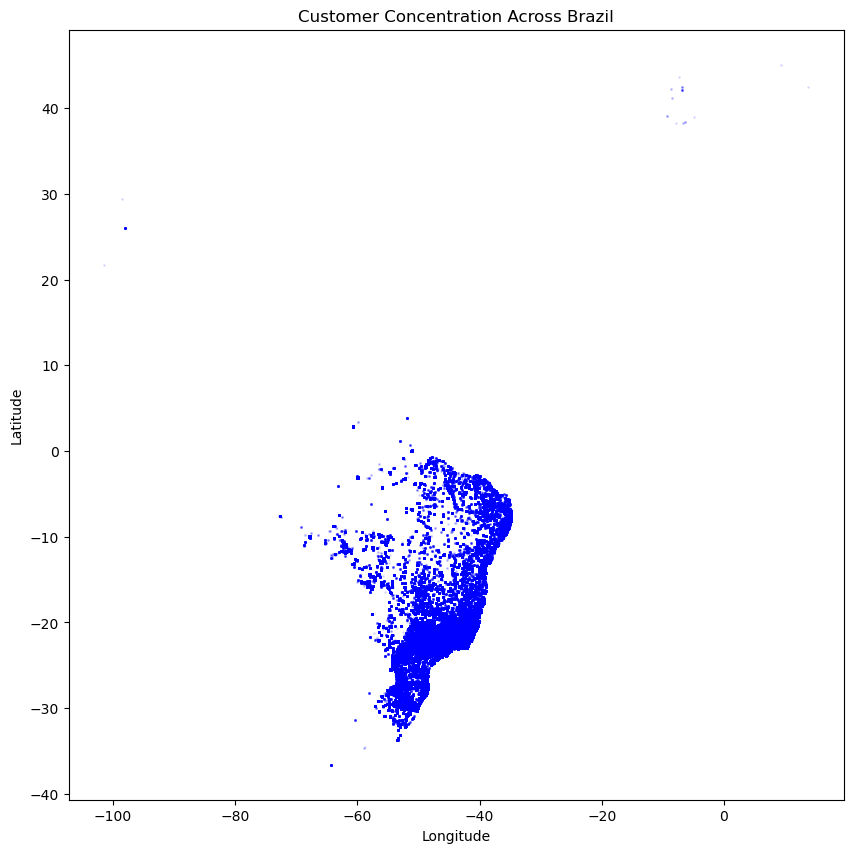

In [85]:

# Geolocation data
geo = pd.read_csv('olist_geolocation_dataset.csv')

# Merge with customer data (via zip code)
geo_data = pd.merge(customers, geo, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')

# Plotting a sample (sampling is necessary because the data is very large)
plt.figure(figsize=(10,10))
plt.scatter(geo_data['geolocation_lng'], geo_data['geolocation_lat'], s=1, alpha=0.1, color='blue')
plt.title('Customer Concentration Across Brazil')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [86]:
# Save the final cleaned master data in CSV
df.to_csv('olist_final_master_data.csv', index=False)
print("Project Data Saved Successfully!")

Project Data Saved Successfully!


In [ ]:
# Pehle check karein ki 'df' exists karta hai ya nahi
if 'df' in locals() or 'df' in globals():
    df.to_csv('olist_final_master_data.csv', index=False)
    print("Mubarak ho! Project Data 'olist_final_master_data.csv' naam se save ho gaya hai.")
else:
    print("Error: 'df' abhi tak bana nahi hai. Pehle merging wala cell run karein!")